# Introduction 

Hello all!

In this notebook I tried to play with some sklearn features while exploring and visualizing the heart disease data we have given. Basically I tried to show distribution of data, relations between variables and target as well as correlations between each other then did some basic model building.

The data includes 303 patient level features including if they have heart disease at the end or not. Features are like;

- Age: Obvious one...
- Sex:
    - 0: Female
    - 1: Male
- Chest Pain Type: 
    - 0: Typical Angina
    - 1: Atypical Angina
    - 2: Non-Anginal Pain
    - 3: Asymptomatic
- Resting Blood Pressure: Person's resting blood pressure.
- Cholesterol: Serum Cholesterol in mg/dl  
- Fasting Blood Sugar:
    - 0:Less Than 120mg/ml
    - 1: Greater Than 120mg/ml
- Resting Electrocardiographic Measurement:
    - 0: Normal
    - 1: ST-T Wave Abnormality
    - 2: Left Ventricular Hypertrophy
- Max Heart Rate Achieved: Maximum Heart Rate Achieved
- Exercise Induced Angina:
    - 1: Yes
    - 0: No
- ST Depression: ST depression induced by exercise relative to rest.
- Slope: Slope of the peak exercise ST segment:
    - 0: Upsloping
    - 1: Flat
    - 2: Downsloping
- Thalassemia: A blood disorder called 'Thalassemia':
    - 0: Normal
    - 1: Fixed Defect
    - 2: Reversable Defect
- Number of Major Vessels: Number of major vessels colored by fluoroscopy.

After doing some usual exploratory data analysis I noticed some of the results doesn't make sense, I ain't no expert in field but made me curious and then I found this topic here [The ultimate guide to this dataset!](https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877), his points made sense so I decided to use this dataset after inspecting it: [Heart Disease Cleveland UCI](https://www.kaggle.com/cherngs/heart-disease-cleveland-uci).

I'd say it gave me more reasonable results and decided to stick with it, both datasets are pretty close but targets are reversed. It's up to you what dataset you choose, the original one gave me better F1 score but as I said EDA didn't make sense to but I have to tell I'm just inspecting the data and have no medical knowledge on the field.

One last note: I used some sklearn features just for the sake of showing them, they might be not needed in actual use for this case...

Well, let's get goin then!

# Loading Data

In [1]:
# Loading packages.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

#

import math
import random
import os
import time

from numpy import interp

# Disabling warnings:

import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Styling:

cust_palt = [
    '#111d5e', '#c70039', '#f37121', '#ffbd69', '#ffc93c'
]

plt.style.use('ggplot')

In [3]:
# Seeding:

def seed_all(seed):
    
    ''' A function to seed everything for getting stable results and reproducibility'''
    
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42    
seed_all(seed)

In [4]:
# Reading csv file:

train = pd.read_csv('../input/heart-disease-cleveland-uci/heart_cleveland_upload.csv')

In [5]:
# Taking random samples from data:

train.head(5)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0

In [6]:
print(
    f'Train data has {train.shape[1]} features, {train.shape[0]} observations.\nTrain features are:\n{train.columns.tolist()}\n'
)

Train data has 14 features, 297 observations.
Train features are:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition']



In [7]:
# Checking null values:

train.isnull().sum().sum()


0

### I decided to rename columns for easier understanding in EDA part.

In [8]:
# Renaming columns.
train.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'condition']



In [9]:
# Number of unique train observartions:

train.nunique()

age                         41
sex                          2
chest_pain_type              4
resting_blood_pressure      50
cholesterol                152
fasting_blood_sugar          2
rest_ecg                     3
max_heart_rate_achieved     91
exercise_induced_angina      2
st_depression               40
st_slope                     3
num_major_vessels            4
thalassemia                  3
condition                    2
dtype: int64

### Again renaming the categorical variables for easier EDA interpretation.

In [10]:
# Renaming cateorical data for easier understanding:

train['sex'] = train['sex'].map({0:'female',1:'male'})

train['chest_pain_type'] = train['chest_pain_type'].map({3:'asymptomatic', 1:'atypical_angina', 2:'non_anginal_pain', 0:'typical_angina'})

train['fasting_blood_sugar'] = train['fasting_blood_sugar'].map({0:'less_than_120mg/ml',1:'greater_than_120mg/ml'})

train['rest_ecg'] = train['rest_ecg'].map({0:'normal',1:'ST-T_wave_abnormality',2:'left_ventricular_hypertrophy'})

train['exercise_induced_angina'] = train['exercise_induced_angina'].map({0:'no',1:'yes'})

train['st_slope'] = train['st_slope'].map({0:'upsloping',1:'flat',2:'downsloping'})

train['thalassemia'] = train['thalassemia'].map({1:'fixed_defect',0:'normal',2:'reversable_defect'})

train['condition'] = train['condition'].map({0:'no_disease', 1:'has_disease'})


In [11]:
# Masks for easier selection in future:

categorical = [i for i in train.loc[:,train.nunique()<=10]]
continuous = [i for i in train.loc[:,train.nunique()>=10]]

In [12]:
def ctg_dist(df, cols, hue=None,rows=3, columns=3):
    
    '''A function for displaying cateorical distribution'''
    
    fig, axes = plt.subplots(rows, columns, figsize=(16, 12))
    axes = axes.flatten()

    for i, j in zip(df[cols].columns, axes):
        sns.countplot(x=i,
                    data=df,
                    palette=cust_palt,
                    hue=hue,
                    ax=j,
                    order=df[i].value_counts().index)
        j.tick_params(labelrotation=10)
        
        total = float(len(df[i]))
        
        j.set_title(f'{str(i).capitalize()} Distribution')
        
        
        for p in j.patches:
            height = p.get_height()
            j.text(p.get_x() + p.get_width() / 2.,
                    height + 2,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha='center')
        
        plt.tight_layout()

# Univariate Analysis

> Univariate analysis is the simplest form of analyzing data. “Uni” means “one”, so in other words your data has only one variable. It doesn't deal with causes or relationships (unlike regression) and it's major purpose is to describe; It takes data, summarizes that data and finds patterns in the data.

#### For this part we going to inspect how's the data distribution is and what patterns we can inspect.

## Categorical Data

### Here we can do these observations:
- Males on the dataset is more than double of the female observations.
- Most common ches pain type is 'Asymptomatic' ones which is almost 50% of the data
- 85% of the patients has no high levels of fastin blood sugar.
- Resing electrocardiographic observations are evenly distributed between normal and left ventricular hypertrophy with ST-T minority
- 67% of the patients had no exercise induced angina
- Peak exercise slope seems mainly divided between upsloping and flat.

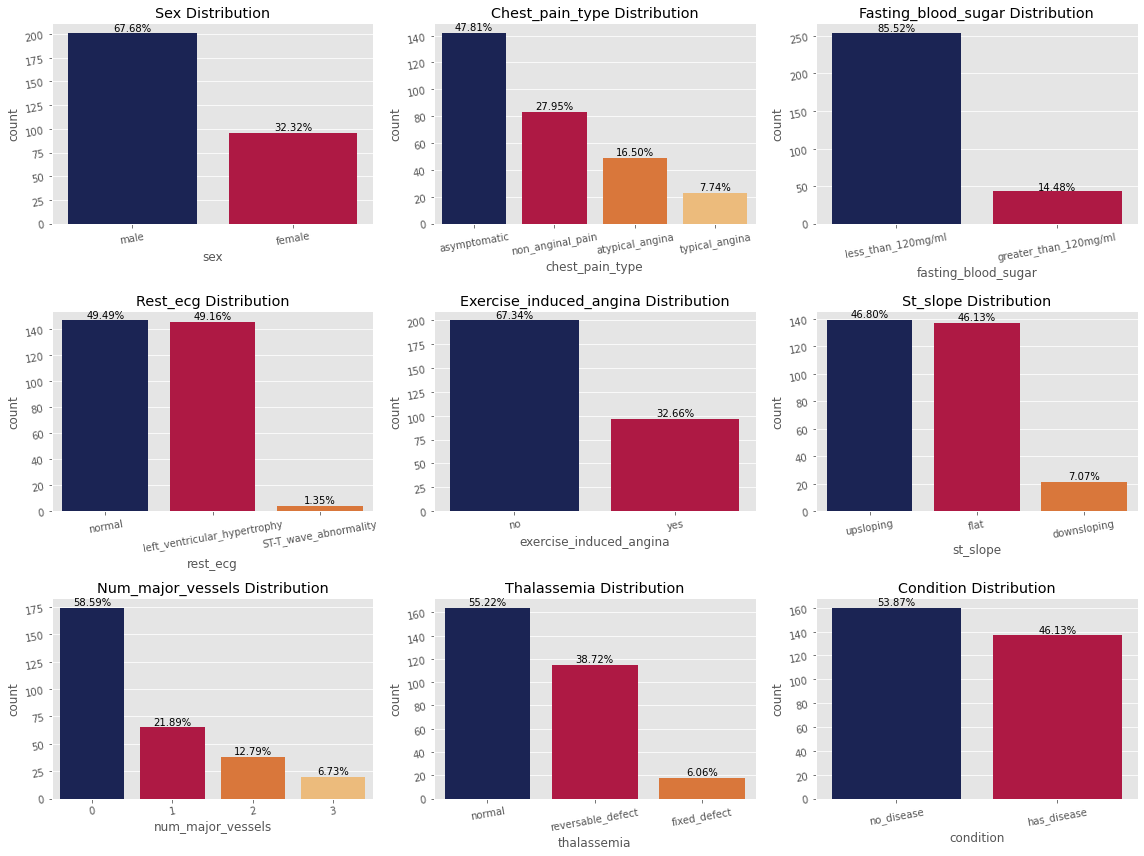

In [13]:
# Display categorical data:

ctg_dist(train, categorical)

## Numerical Data

### Most of the continuous variables somewhat close to gaussian distribution with small skews left or right except for oldpeak. Again there are some outliers espacially a strong one in Cholesterol worth to take a look later.

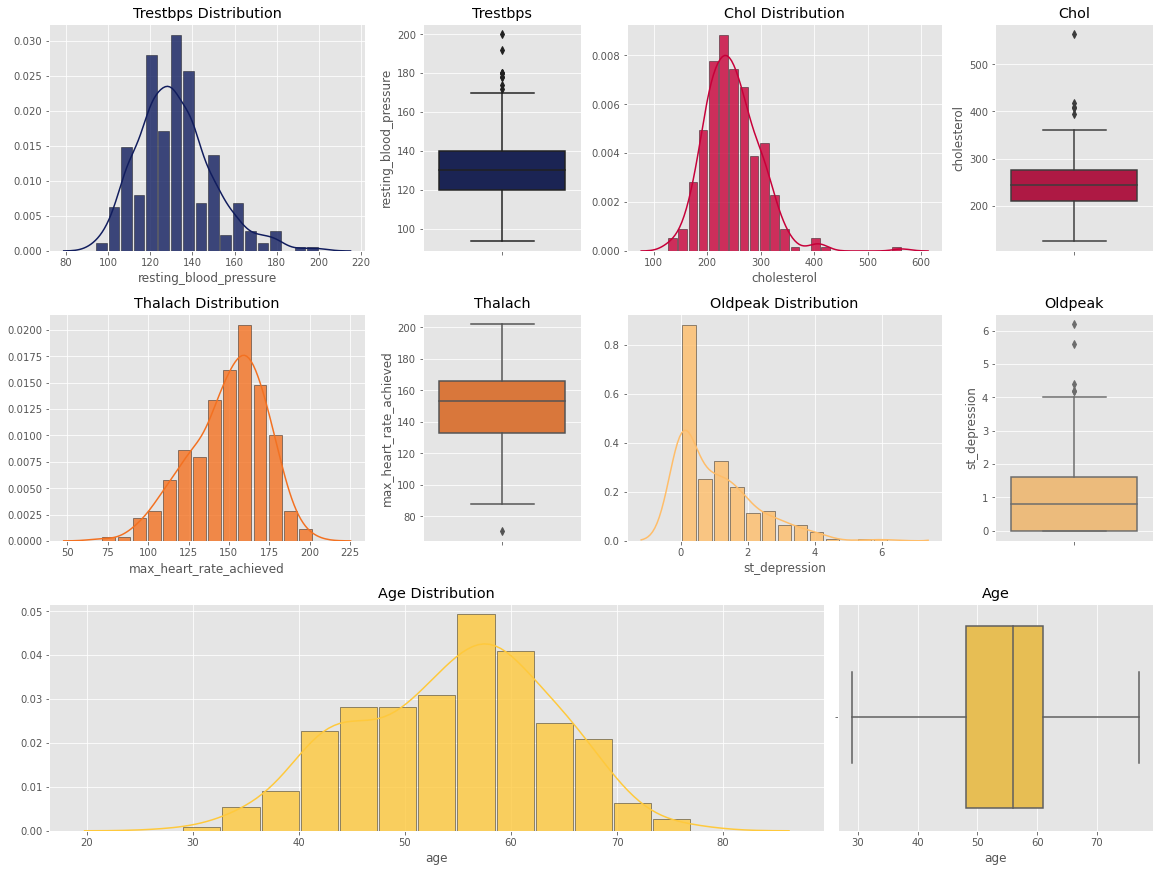

In [14]:
# Displaying numeric distribution:

fig = plt.figure(constrained_layout=True, figsize=(16, 12))


grid = gridspec.GridSpec(ncols=6, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

ax1.set_title('Trestbps Distribution')

sns.distplot(train[continuous[1]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[0])

ax15 = fig.add_subplot(grid[0, 2:3])

ax15.set_title('Trestbps')

sns.boxplot(train[continuous[1]], orient='v', color=cust_palt[0])

ax2 = fig.add_subplot(grid[0, 3:5])

ax2.set_title('Chol Distribution')

sns.distplot(train[continuous[2]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[1])

ax25 = fig.add_subplot(grid[0, 5:])

ax25.set_title('Chol')

sns.boxplot(train[continuous[2]], orient='v', color=cust_palt[1])

ax3 = fig.add_subplot(grid[1, :2])

ax3.set_title('Thalach Distribution')

sns.distplot(train[continuous[3]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[2])

ax35 = fig.add_subplot(grid[1, 2:3])

ax35.set_title('Thalach')

sns.boxplot(train[continuous[3]], orient='v', color=cust_palt[2])

ax4 = fig.add_subplot(grid[1, 3:5])

ax4.set_title('Oldpeak Distribution')

sns.distplot(train[continuous[4]],
                 hist_kws={
                 'rwidth': 0.85,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[3])

ax45 = fig.add_subplot(grid[1, 5:])

ax45.set_title('Oldpeak')

sns.boxplot(train[continuous[4]], orient='v', color=cust_palt[3])

ax5 = fig.add_subplot(grid[2, :4])

ax5.set_title('Age Distribution')

sns.distplot(train[continuous[0]],
                 hist_kws={
                 'rwidth': 0.95,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color=cust_palt[4])

ax55 = fig.add_subplot(grid[2, 4:])

ax55.set_title('Age')

sns.boxplot(train[continuous[0]], orient='h', color=cust_palt[4])

plt.show()


# Bivariate Analysis

> Bivariate analysis is one of the simplest forms of quantitative analysis. It involves the analysis of two variables, for the purpose of determining the empirical relationship between them. Bivariate analysis can be helpful in testing simple hypotheses of association.

In this part we goin to take our variables and compare them against our target condition which is if the observed patient has disease or not.

## Categorical Data vs Target

### Here we can do these observations:

- Males are much more likely for heart diseases.
- Chest pain type is very subjective and has no direct relation on the outcome, asymptomatic chest pains having highest disease outcome.
- Blood sugar has no direct effect on the disease.
- Rest ECG results showing no direct results but having normal ECG is pretty good sign. Even though it's pretty rare in the data, if you ST-T wave abnormality you are 3 times more likely to have heart disease.
- Having exercise induced angina is pretty strong indicator for heart disease, patients are almost 3 times more likely to have disease if they have exercise induced angina. Meanwhile it's less than half for not having it.
- Patients who had flat slope distribution are more likely to have disease.
- Number of major vessels observed seems on similar levels for patients who have disease but 0 observations is good sign for not having disease.
- Having defected thalium test results is pretty strong indicator for heart disease.

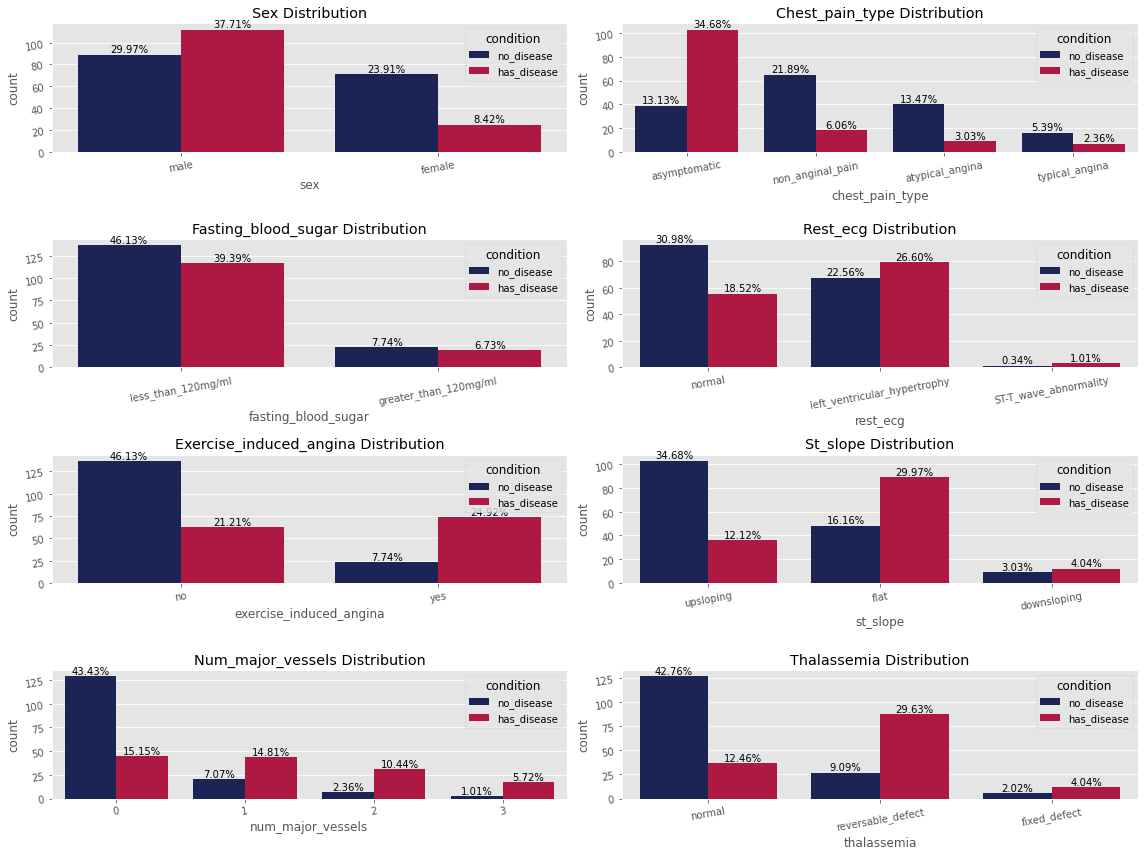

In [15]:
# Categorical data vs condition:

ctg_dist(train, categorical[:-1], 'condition', 4, 2)

## Numerical Data vs Target

### Here we can do these observations:

- Having higher resting blood pressure shows you are little bit more likely to have heart disease.
- Again same for Cholesterol, it's not strong indicator but patients are little bit more likely to have disease with high cholesterol. There's is also one outlier there with no disease, pretty interesting.
- I find max heart rate distribution a bit interesting, expecting the other way around but it might be due to testing conditions and if you have normal results on ECG while exercising instructors might be increasing your excercise density?
- It's pretty clear that heart disease likelihood increases with ST depression levels...
- Lastly older patients are more likely to have heart disease.

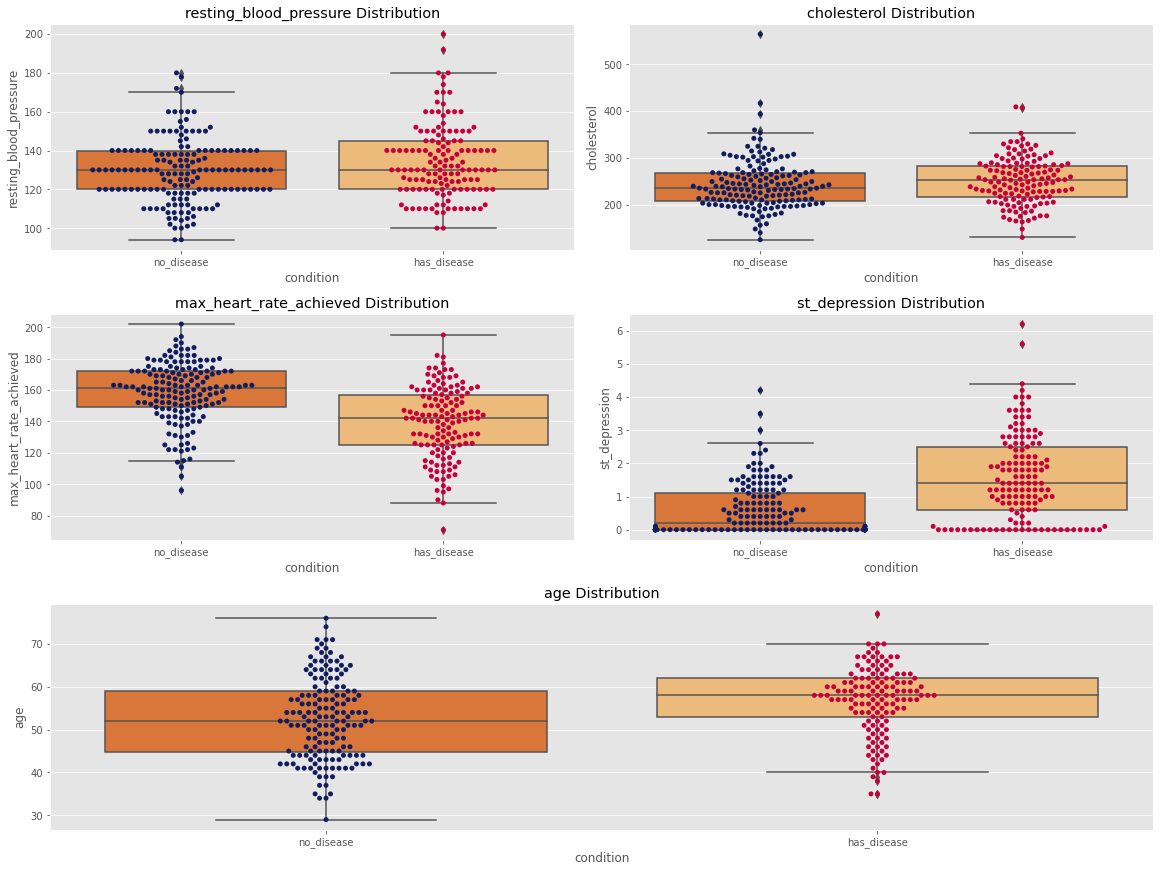

In [16]:
# Displaying numeric distribution vs condition:

fig = plt.figure(constrained_layout=True, figsize=(16, 12))


grid = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

ax1.set_title('resting_blood_pressure Distribution')

sns.boxplot(x='condition',
                    y='resting_blood_pressure',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax1)
sns.swarmplot(x='condition',
                    y='resting_blood_pressure',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax1)

ax2 = fig.add_subplot(grid[0, 2:])

ax2.set_title('cholesterol Distribution')

sns.boxplot(x='condition',
                    y='cholesterol',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax2)
sns.swarmplot(x='condition',
                    y='cholesterol',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax2)

ax3 = fig.add_subplot(grid[1, :2])

ax3.set_title('max_heart_rate_achieved Distribution')

sns.boxplot(x='condition',
                    y='max_heart_rate_achieved',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax3)
sns.swarmplot(x='condition',
                    y='max_heart_rate_achieved',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax3)

ax4 = fig.add_subplot(grid[1, 2:])

ax4.set_title('st_depression Distribution')

sns.boxplot(x='condition',
                    y='st_depression',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax4)
sns.swarmplot(x='condition',
                    y='st_depression',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax4)

ax5 = fig.add_subplot(grid[2, :])

ax5.set_title('age Distribution')

sns.boxplot(x='condition',
                    y='age',
                    data=train,
                    palette=cust_palt[2:],
                    ax=ax5)
sns.swarmplot(x='condition',
                    y='age',
                    data=train,
                    palette=cust_palt[:2],
                    ax=ax5)
plt.show()

# Multivariate Analysis

> Multivariate analysis (MVA) is based on the principles of multivariate statistics, which involves observation and analysis of more than one statistical outcome variable at a time. Typically, MVA is used to address the situations where multiple measurements are made on each experimental unit and the relations among these measurements and their structures are important.

<Figure size 1152x720 with 0 Axes>

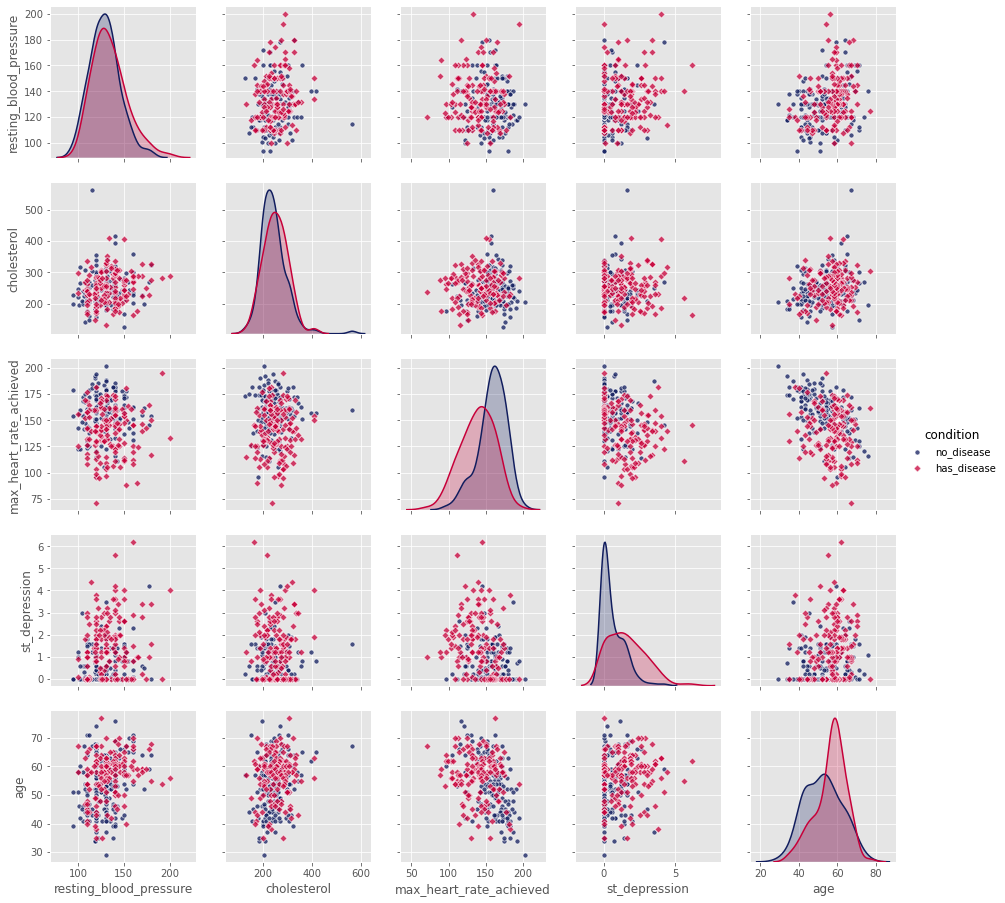

In [17]:
# Numeric data vs each other and condition:

plt.figure(figsize=(16, 10))
sns.pairplot(train[['resting_blood_pressure','cholesterol','max_heart_rate_achieved','st_depression','age', 'condition']], hue='condition', palette=cust_palt,
           markers=['o','D'], plot_kws=dict(s=25, alpha=0.75, ci=None)
            )

plt.show()

## Cholesterol, Max Heart Rate, Age, St Depression vs Target

### Here I tried to fit every single numerical feature into one graph so we can have some visualized version of the effects. 3D scatterplot is great tool for doing that...

#### On X axis we have Cholesterol levels, on Y Max Heart Rate presented and Z axis is patient Age, marker sizes are based on ST_Depression levels and coloring based on the patient condition.

In [18]:
# 3D scatterplot of numeric data:

fig = px.scatter_3d(train, x='cholesterol', y='max_heart_rate_achieved', z='age', size='st_depression',
              color='condition', opacity=0.8)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

# Inspecting Age Closer

In [19]:
def ctn_freq(df, cols, xaxi, hue=None,rows=4, columns=1):
    
    ''' A function for displaying numerical data frequency vs age and condition '''
    
    fig, axes = plt.subplots(rows, columns, figsize=(16, 12), sharex=True)
    axes = axes.flatten()

    for i, j in zip(df[cols].columns, axes):
        sns.pointplot(x=xaxi,
                      y=i,
                    data=df,
                    palette=cust_palt[:2],
                    hue=hue,
                    ax=j,ci=False)      
        j.set_title(f'{str(i).capitalize()} vs. Age')

        
        plt.tight_layout()

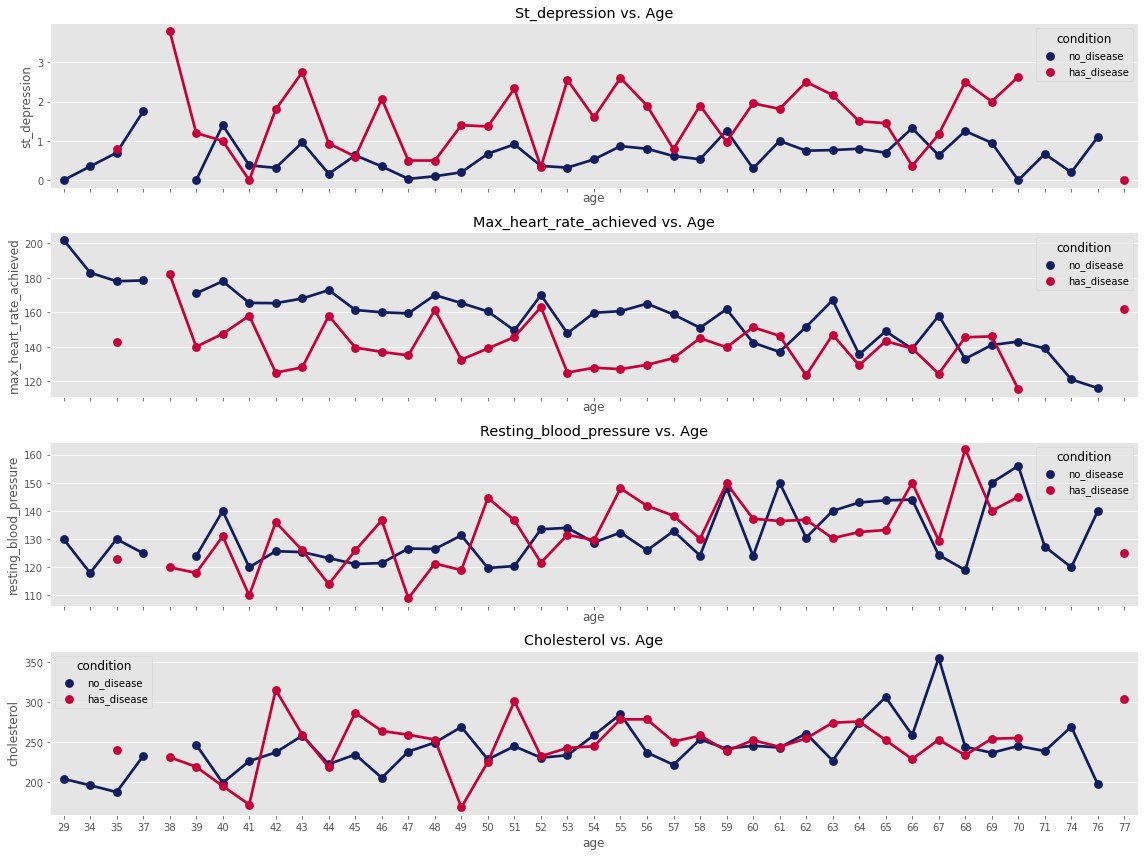

In [20]:
ctn_freq(train, ['st_depression','max_heart_rate_achieved','resting_blood_pressure','cholesterol'], 'age', hue='condition',rows=4, columns=1)

In [21]:
# Loading data for corrmap:

heat_train = pd.read_csv('../input/heart-disease-cleveland-uci/heart_cleveland_upload.csv')

# Correlations

#### We going to use pearson correlation for to find linear relations between features, heatmap is decent way to show these relations.

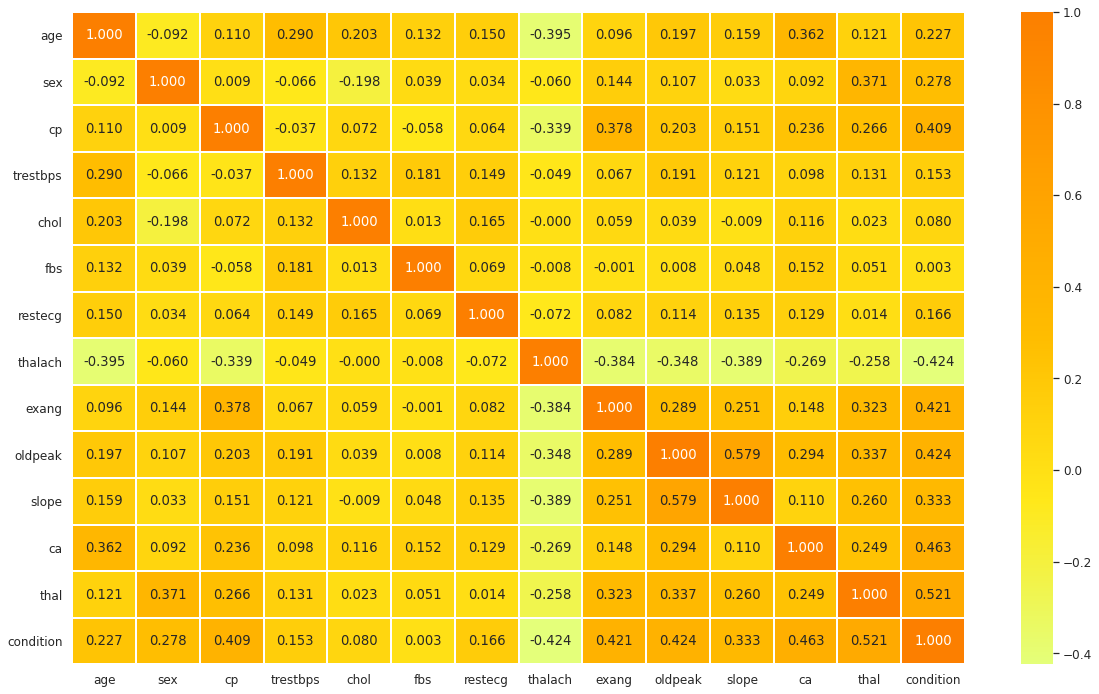

In [22]:
# Correlation heatmap between variables:

sns.set(font_scale=1.1)
correlation_train = heat_train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='Wistia',
            linewidths=1,
            cbar=True)

plt.show()

### Here I chose top related features with outcome condition, seems thal is the most correlated one...

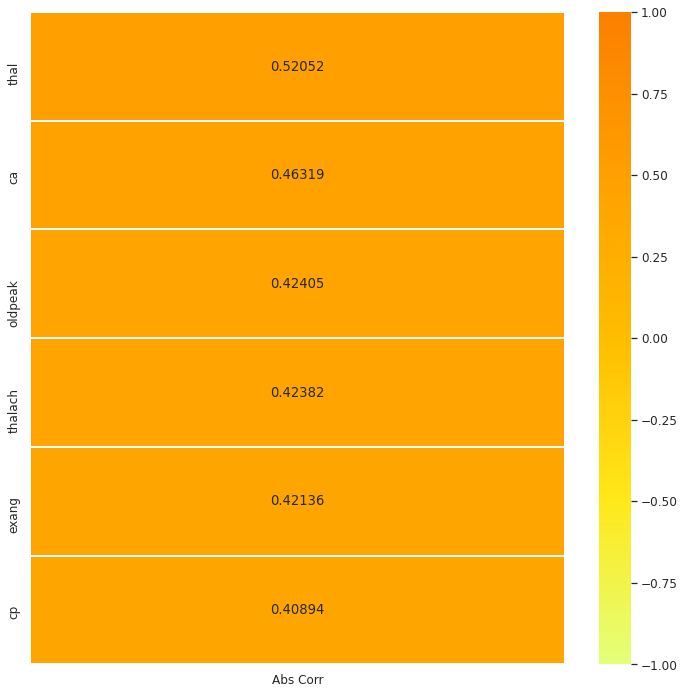

In [23]:
# Top correlated variables vs condition:

correlations = heat_train.corrwith(heat_train['condition']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.35], cmap='Wistia', annot=True, vmin=-1, vmax=1,linewidths=1,fmt='.5f', ax=ax);

# Modelling

### Ok... Here's the fun part, who doesn't love a bit of modelling? We start by loading our train data and labels as X and y's and we get dummy variables for categorical data using one hot encoding. Then we import loads of sklearn modules.

In [24]:
# Setting train and condition data:

X = train.drop('condition', axis=1)
y = heat_train['condition']

In [25]:
# One hot encoding train features:

ctg_df = pd.get_dummies(data=train[['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'st_slope', 'num_major_vessels', 'thalassemia']])
X.drop(['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'st_slope', 'num_major_vessels', 'thalassemia'], axis=1, inplace=True)
X = pd.concat([X, ctg_df], axis=1)

In [26]:
# Loading sklearn packages:

from sklearn.model_selection import cross_validate, KFold, learning_curve,  cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix

# Classifiers

### Here I selected some common sklearn classifiers, I didn't want to include some common ml algorithms like xgboost, lightgbm or catboost since I wanted to play with sklearn only for this notebook. I'll do small quotes for each classifier from sklearn's official page:

## GradientBoostingClassifier

> Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology.

## KNeighborsClassifier

> Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

## DecisionTreeClassifier

> Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

## Support Vector Machines

> Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.
- The advantages of support vector machines are:
    - Effective in high dimensional spaces.
    - Still effective in cases where number of dimensions is greater than the number of samples.
    - Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
    - Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.
    
## RandomForestClassifier

>The sklearn.ensemble module includes two averaging algorithms based on randomized decision trees: the RandomForest algorithm and the Extra-Trees method. Both algorithms are perturb-and-combine technique specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

## AdaBoostClassifier

> An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

## MLP Classifier

> Multi-layer Perceptron classifier.
This model optimizes the log-loss function using LBFGS or stochastic gradient descent.

## GaussianNB

> GaussianNB implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian.


### Ok... Let's get building them.

In [27]:
# Selecting some sklearn classifiers:

gradclass = GradientBoostingClassifier(random_state=seed)

knclass = KNeighborsClassifier()

dectree = DecisionTreeClassifier(random_state=seed)

svc = SVC()

randfclass = RandomForestClassifier(random_state=seed)

adaclass = AdaBoostClassifier(random_state=seed)

mlpclass = MLPClassifier(random_state=seed)

gsclass = GaussianNB()

In [28]:
# Setting 5 fold CV:

cv = KFold(5, shuffle=True, random_state=seed)

classifiers = [gradclass, knclass, dectree, svc, randfclass, adaclass, mlpclass, gsclass]

In [29]:
def model_check(X, y, classifiers, cv):
    
    ''' A function for testing multiple classifiers and return several metrics. '''
    
    model_table = pd.DataFrame()

    row_index = 0
    for cls in classifiers:

        MLA_name = cls.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name
        
        cv_results = cross_validate(
            cls,
            X,
            y,
            cv=cv,
            scoring=('accuracy','f1','roc_auc'),
            return_train_score=True,
            n_jobs=-1
        )
        model_table.loc[row_index, 'Train Roc/AUC Mean'] = cv_results[
            'train_roc_auc'].mean()
        model_table.loc[row_index, 'Test Roc/AUC Mean'] = cv_results[
            'test_roc_auc'].mean()
        model_table.loc[row_index, 'Test Roc/AUC Std'] = cv_results['test_roc_auc'].std()
        model_table.loc[row_index, 'Train Accuracy Mean'] = cv_results[
            'train_accuracy'].mean()
        model_table.loc[row_index, 'Test Accuracy Mean'] = cv_results[
            'test_accuracy'].mean()
        model_table.loc[row_index, 'Test Acc Std'] = cv_results['test_accuracy'].std()
        model_table.loc[row_index, 'Train F1 Mean'] = cv_results[
            'train_f1'].mean()
        model_table.loc[row_index, 'Test F1 Mean'] = cv_results[
            'test_f1'].mean()
        model_table.loc[row_index, 'Test F1 Std'] = cv_results['test_f1'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1        

    model_table.sort_values(by=['Test F1 Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

# Baseline Results

### We have many metrics but I decided to sort them by F1 score since precision and recall is pretty important on this case. Looking at our first results showing RandomForestClassifier is the best performing one in the list of not tuned classifiers, followed by MLP and GradientBoosting classifiers.

### But we can see most of our decision tree based models are overfitting, that's something we should take a look at soon...

In [30]:
# Baseline check:

raw_models = model_check(X, y, classifiers, cv)

display(raw_models)

Model Name  Train Roc/AUC Mean  Test Roc/AUC Mean  \
4      RandomForestClassifier            1.000000           0.908139   
6               MLPClassifier            0.943029           0.905784   
0  GradientBoostingClassifier            0.999972           0.885312   
7                  GaussianNB            0.901929           0.893879   
5          AdaBoostClassifier            0.986810           0.864971   
2      DecisionTreeClassifier            1.000000           0.731797   
1        KNeighborsClassifier            0.847549           0.686335   
3                         SVC            0.761350           0.736696   

   Test Roc/AUC Std  Train Accuracy Mean  Test Accuracy Mean  Test Acc Std  \
4          0.046801             1.000000            0.831695      0.052705   
6          0.053989             0.868705            0.818192      0.056538   
0          0.053211             0.995791            0.814972      0.063174   
7          0.032092             0.836702            0.811695      0.052721   
5          0.064461             0.929309            0.787853      0.070837   
2          0.050374             1.000000            0.730395      0.050089   
1          0.058361             0.770177            0.650169      0.057531   
3          0.077651             0.678453            0.666836      0.052064   

   Train F1 Mean  Test F1 Mean  Test F1 Std      Time  
4       1.000000      0.812917     0.056677  0.305575  
6       0.848979      0.796519     0.059191  0.567375  
0       0.995487      0.795906     0.062559  0.155577  
7       0.814794      0.790126     0.053867  0.006092  
5       0.922778      0.763340     0.074706  0.149268  
2       1.000000      0.706855     0.053486  0.008421  
1       0.745321      0.595780     0.068374  0.006068  
3       0.577783      0.562758     0.061458  0.010387

In [31]:
def f_imp(classifiers, X, y, bins):
    
    ''' A function for displaying feature importances'''
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    axes = axes.flatten()

    for ax, classifier in zip(axes, classifiers):

        try:
            classifier.fit(X, y)
            feature_imp = pd.DataFrame(sorted(
                zip(classifier.feature_importances_, X.columns)),
                                       columns=['Value', 'Feature'])

            sns.barplot(x="Value",
                        y="Feature",
                        data=feature_imp.sort_values(by="Value",
                                                     ascending=False),
                        ax=ax,
                        palette='plasma')
            plt.title('Features')
            plt.tight_layout()
            ax.set(title=f'{classifier.__class__.__name__} Feature Impotances')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=bins))
        except:
            continue
    plt.show()



## Since our decision tree based models overfitting I wanted to look which features are most effecting these decisions, I sampled two of the tree based models you can see below:

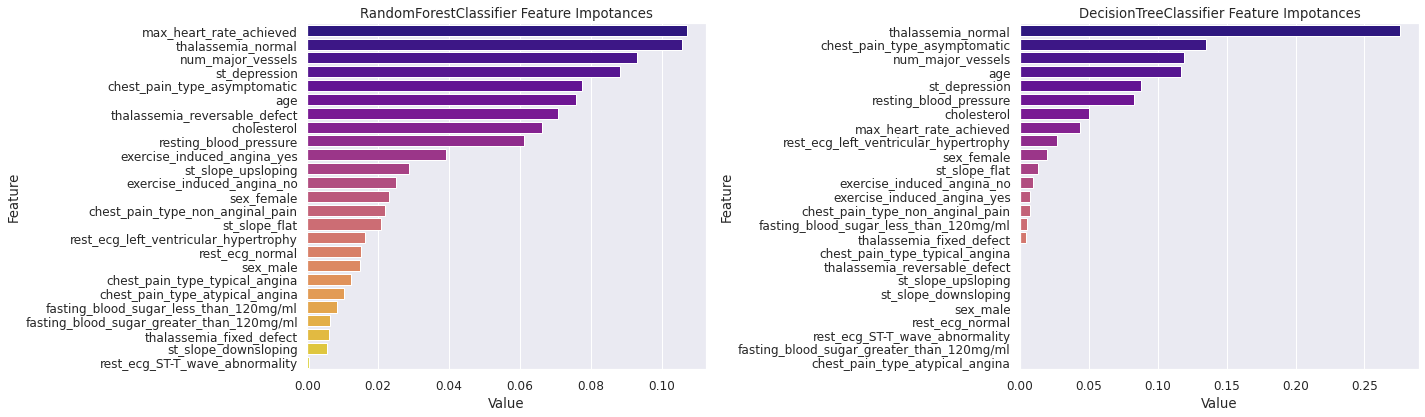

In [32]:
# Feature importances:

f_imp([randfclass,dectree], X, y, 6)

# Automatic Outlier Detection

## Before going to tune our models I decided to get rid of some outliers, we have pretty small database and we can actually remove them by hand or more basic methods. But I wanted to use what sklearn can offer us for this so we gonna try couple sklearn features.

# Isolation Forest

    The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

    Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

    This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

    Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

Basically I set contamination rate of our data to 10% and dropped them using masks. It didn't do great on the results, we have pretty small dataset and removing some more damaging model performances probably. But it's ok for now...

In [33]:
# Applying Isolation Forest:

iso = IsolationForest(contamination=0.1,random_state=seed)
yhat = iso.fit_predict(X)

mask = (yhat != -1)

X_iso = X.loc[mask, :]
y_iso= y[mask]

In [34]:
# Checking isolated models:

iso_models = model_check(X_iso, y_iso, classifiers, cv)
display(iso_models)

Model Name  Train Roc/AUC Mean  Test Roc/AUC Mean  \
7                  GaussianNB            0.911465           0.878511   
0  GradientBoostingClassifier            1.000000           0.881188   
4      RandomForestClassifier            1.000000           0.896893   
6               MLPClassifier            0.929163           0.880803   
5          AdaBoostClassifier            0.991044           0.848844   
2      DecisionTreeClassifier            1.000000           0.749620   
1        KNeighborsClassifier            0.836381           0.686548   
3                         SVC            0.760132           0.735924   

   Test Roc/AUC Std  Train Accuracy Mean  Test Accuracy Mean  Test Acc Std  \
7          0.039401             0.834259            0.808945      0.043297   
0          0.020325             0.998126            0.812718      0.012055   
4          0.019932             1.000000            0.801328      0.033744   
6          0.011143             0.833338            0.793920      0.027040   
5          0.024452             0.951327            0.775262      0.011891   
2          0.026192             1.000000            0.756674      0.025272   
1          0.093458             0.760335            0.663103      0.082195   
3          0.040801             0.676034            0.655625      0.081963   

   Train F1 Mean  Test F1 Mean  Test F1 Std      Time  
7       0.817561      0.793670     0.029050  0.005665  
0       0.997799      0.784525     0.042853  0.153750  
4       1.000000      0.766313     0.058321  0.304321  
6       0.817724      0.761725     0.060409  0.367873  
5       0.945263      0.739753     0.025403  0.143148  
2       1.000000      0.720922     0.039039  0.006541  
1       0.718739      0.598791     0.071875  0.004879  
3       0.538764      0.510568     0.067872  0.009950

# Elliptic Envelope

Let's try another automatic outlier detection method. We assumed our distribution close to gaussian while inspecting the data so elliptic envelope worth to take a look.

> The Minimum Covariance Determinant (MCD) method is a highly robust estimator of multivariate location and scatter, for which a fast algorithm is available. […] It also serves as a convenient and efficient tool for outlier detection.

This one did a little bit better than isolation forest so let's stick with it for this case...

In [35]:
# Applying Elliptical Envelope:

eli = EllipticEnvelope(contamination=0.1,assume_centered=True, random_state=seed)
yhat = eli.fit_predict(X)

mask = (yhat != -1)

X_eli = X.loc[mask, :]
y_eli= y[mask]

In [36]:
eli_models = model_check(X_eli, y_eli, classifiers, cv)
display(eli_models)

Model Name  Train Roc/AUC Mean  Test Roc/AUC Mean  \
4      RandomForestClassifier            1.000000           0.919275   
7                  GaussianNB            0.916159           0.870589   
6               MLPClassifier            0.944630           0.910871   
0  GradientBoostingClassifier            1.000000           0.887499   
5          AdaBoostClassifier            0.993963           0.841003   
2      DecisionTreeClassifier            1.000000           0.746842   
1        KNeighborsClassifier            0.847586           0.716717   
3                         SVC            0.770311           0.743388   

   Test Roc/AUC Std  Train Accuracy Mean  Test Accuracy Mean  Test Acc Std  \
4          0.021966             1.000000            0.846681      0.040655   
7          0.071691             0.850226            0.809154      0.077926   
6          0.015639             0.840845            0.812788      0.042725   
0          0.020638             1.000000            0.816702      0.032942   
5          0.009285             0.956935            0.782739      0.019465   
2          0.076032             1.000000            0.757023      0.059556   
1          0.036866             0.766825            0.689238      0.047509   
3          0.046079             0.683533            0.639972      0.061212   

   Train F1 Mean  Test F1 Mean  Test F1 Std      Time  
4       1.000000      0.819193     0.079252  0.296702  
7       0.831201      0.790047     0.096169  0.005742  
6       0.807983      0.777867     0.063380  0.424819  
0       1.000000      0.777622     0.086544  0.151157  
5       0.952441      0.753855     0.035578  0.146203  
2       1.000000      0.708480     0.126652  0.008521  
1       0.741594      0.642896     0.084697  0.005759  
3       0.584611      0.511984     0.063214  0.009804

# Discretization

    Discretization (otherwise known as quantization or binning) provides a way to partition continuous features into discrete values. Certain datasets with continuous features may benefit from discretization, because discretization can transform the dataset of continuous attributes to one with only nominal attributes.

    One-hot encoded discretized features can make a model more expressive, while maintaining interpretability. For instance, pre-processing with a discretizer can introduce nonlinearity to linear models.

### Since we have small and noisy data I thougt binning them would be better choice of action, for this purpose I'm going to choose another sklearn tool:

## K-Bbins Discretization

### This method discretizes features into 'k' bins. Sklearn module takes several strategy parameters but we going to use 'kmeans' strategy which defines bins based on a k-means clustering procedure performed on each feature independently.

In [37]:
def kbin_cat(col, X, nbins=5):
    
    ''' A function for binning multiple numeric columns'''
    
    categorize = KBinsDiscretizer(n_bins = nbins, encode = 'onehot', strategy = 'kmeans')
    cat = categorize.fit_transform(X[col].values.reshape(-1,1))
    cat= pd.DataFrame(cat.toarray())
    cat_n = [f'cat_{str(i)}' for i in range(nbins)]
    cat.columns = [i.replace('cat',f'{str(col)}') for i in cat_n]
    cat = cat.astype('int')
    
    return cat

In [38]:
# Applying K-bins discretizer:

rt = ['age','resting_blood_pressure','cholesterol', 'max_heart_rate_achieved','st_depression']
X_cat = X_eli
for i in rt:    
    X_cat = X_cat.join(kbin_cat(i,X,5))
    X_cat.drop(i, axis=1, inplace=True)

### By looking at the results binning improved some models little but few of them like SVC got huge boost to their score. (F1 score 0.44 > 0.80)

In [39]:
binn_models = model_check(X_cat, y_eli, classifiers, cv)
display(binn_models)

Model Name  Train Roc/AUC Mean  Test Roc/AUC Mean  \
3                         SVC            0.979696           0.911395   
1        KNeighborsClassifier            0.948720           0.887218   
6               MLPClassifier            0.989016           0.912274   
4      RandomForestClassifier            1.000000           0.913595   
5          AdaBoostClassifier            0.959689           0.858796   
0  GradientBoostingClassifier            0.998289           0.903507   
2      DecisionTreeClassifier            1.000000           0.755296   
7                  GaussianNB            0.910170           0.859576   

   Test Roc/AUC Std  Train Accuracy Mean  Test Accuracy Mean  Test Acc Std  \
3          0.019174             0.934452            0.839203      0.033486   
1          0.028523             0.866118            0.831656      0.038539   
6          0.024780             0.960664            0.828022      0.038418   
4          0.017004             1.000000            0.831796      0.049027   
5          0.024004             0.887662            0.805521      0.033007   
0          0.024406             0.988767            0.794270      0.043084   
2          0.034422             1.000000            0.756604      0.031068   
7          0.054004             0.791225            0.763802      0.070959   

   Train F1 Mean  Test F1 Mean  Test F1 Std      Time  
3       0.928033      0.814671     0.059900  0.009409  
1       0.847943      0.804003     0.068432  0.005580  
6       0.957070      0.803556     0.069567  0.580339  
4       1.000000      0.798089     0.091025  0.310968  
5       0.877052      0.777374     0.053962  0.153096  
0       0.987685      0.761383     0.077073  0.146829  
2       1.000000      0.729606     0.048169  0.007354  
7       0.731303      0.692745     0.117705  0.006123

# Learning Curves

### Before finalizing our modelling I wanted to use another tool sklearn offers: Learning Curves. That can show us how fast the models learning and especially how is the model doing with the number of data given so we can decide if more data needed for better results. In our case we can see that some models overfitting and most of our models can get better with the more data...

In [40]:
def plot_learning_curve(classifiers,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    ''' A function for displaying learning curvers fur multiple ml algorithms'''

    fig, axes = plt.subplots(math.ceil(len(classifiers) / 2),
                             2,
                             figsize=(25, 50))
    axes = axes.flatten()

    for ax, classifier in zip(axes, classifiers):

        ax.set_title(f'{classifier.__class__.__name__} Learning Curve')
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(classifier, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True, scoring='f1', random_state=seed
                          )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve

        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1,
                        color='r')
        ax.fill_between(train_sizes,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.1,
                        color='g')
        ax.plot(train_sizes,
                train_scores_mean,
                'o-',
                color='r',
                label='Training score')
        ax.plot(train_sizes,
                test_scores_mean,
                'o-',
                color='g',
                label='Cross-validation score')
        ax.legend(loc='best')
        ax.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.show()

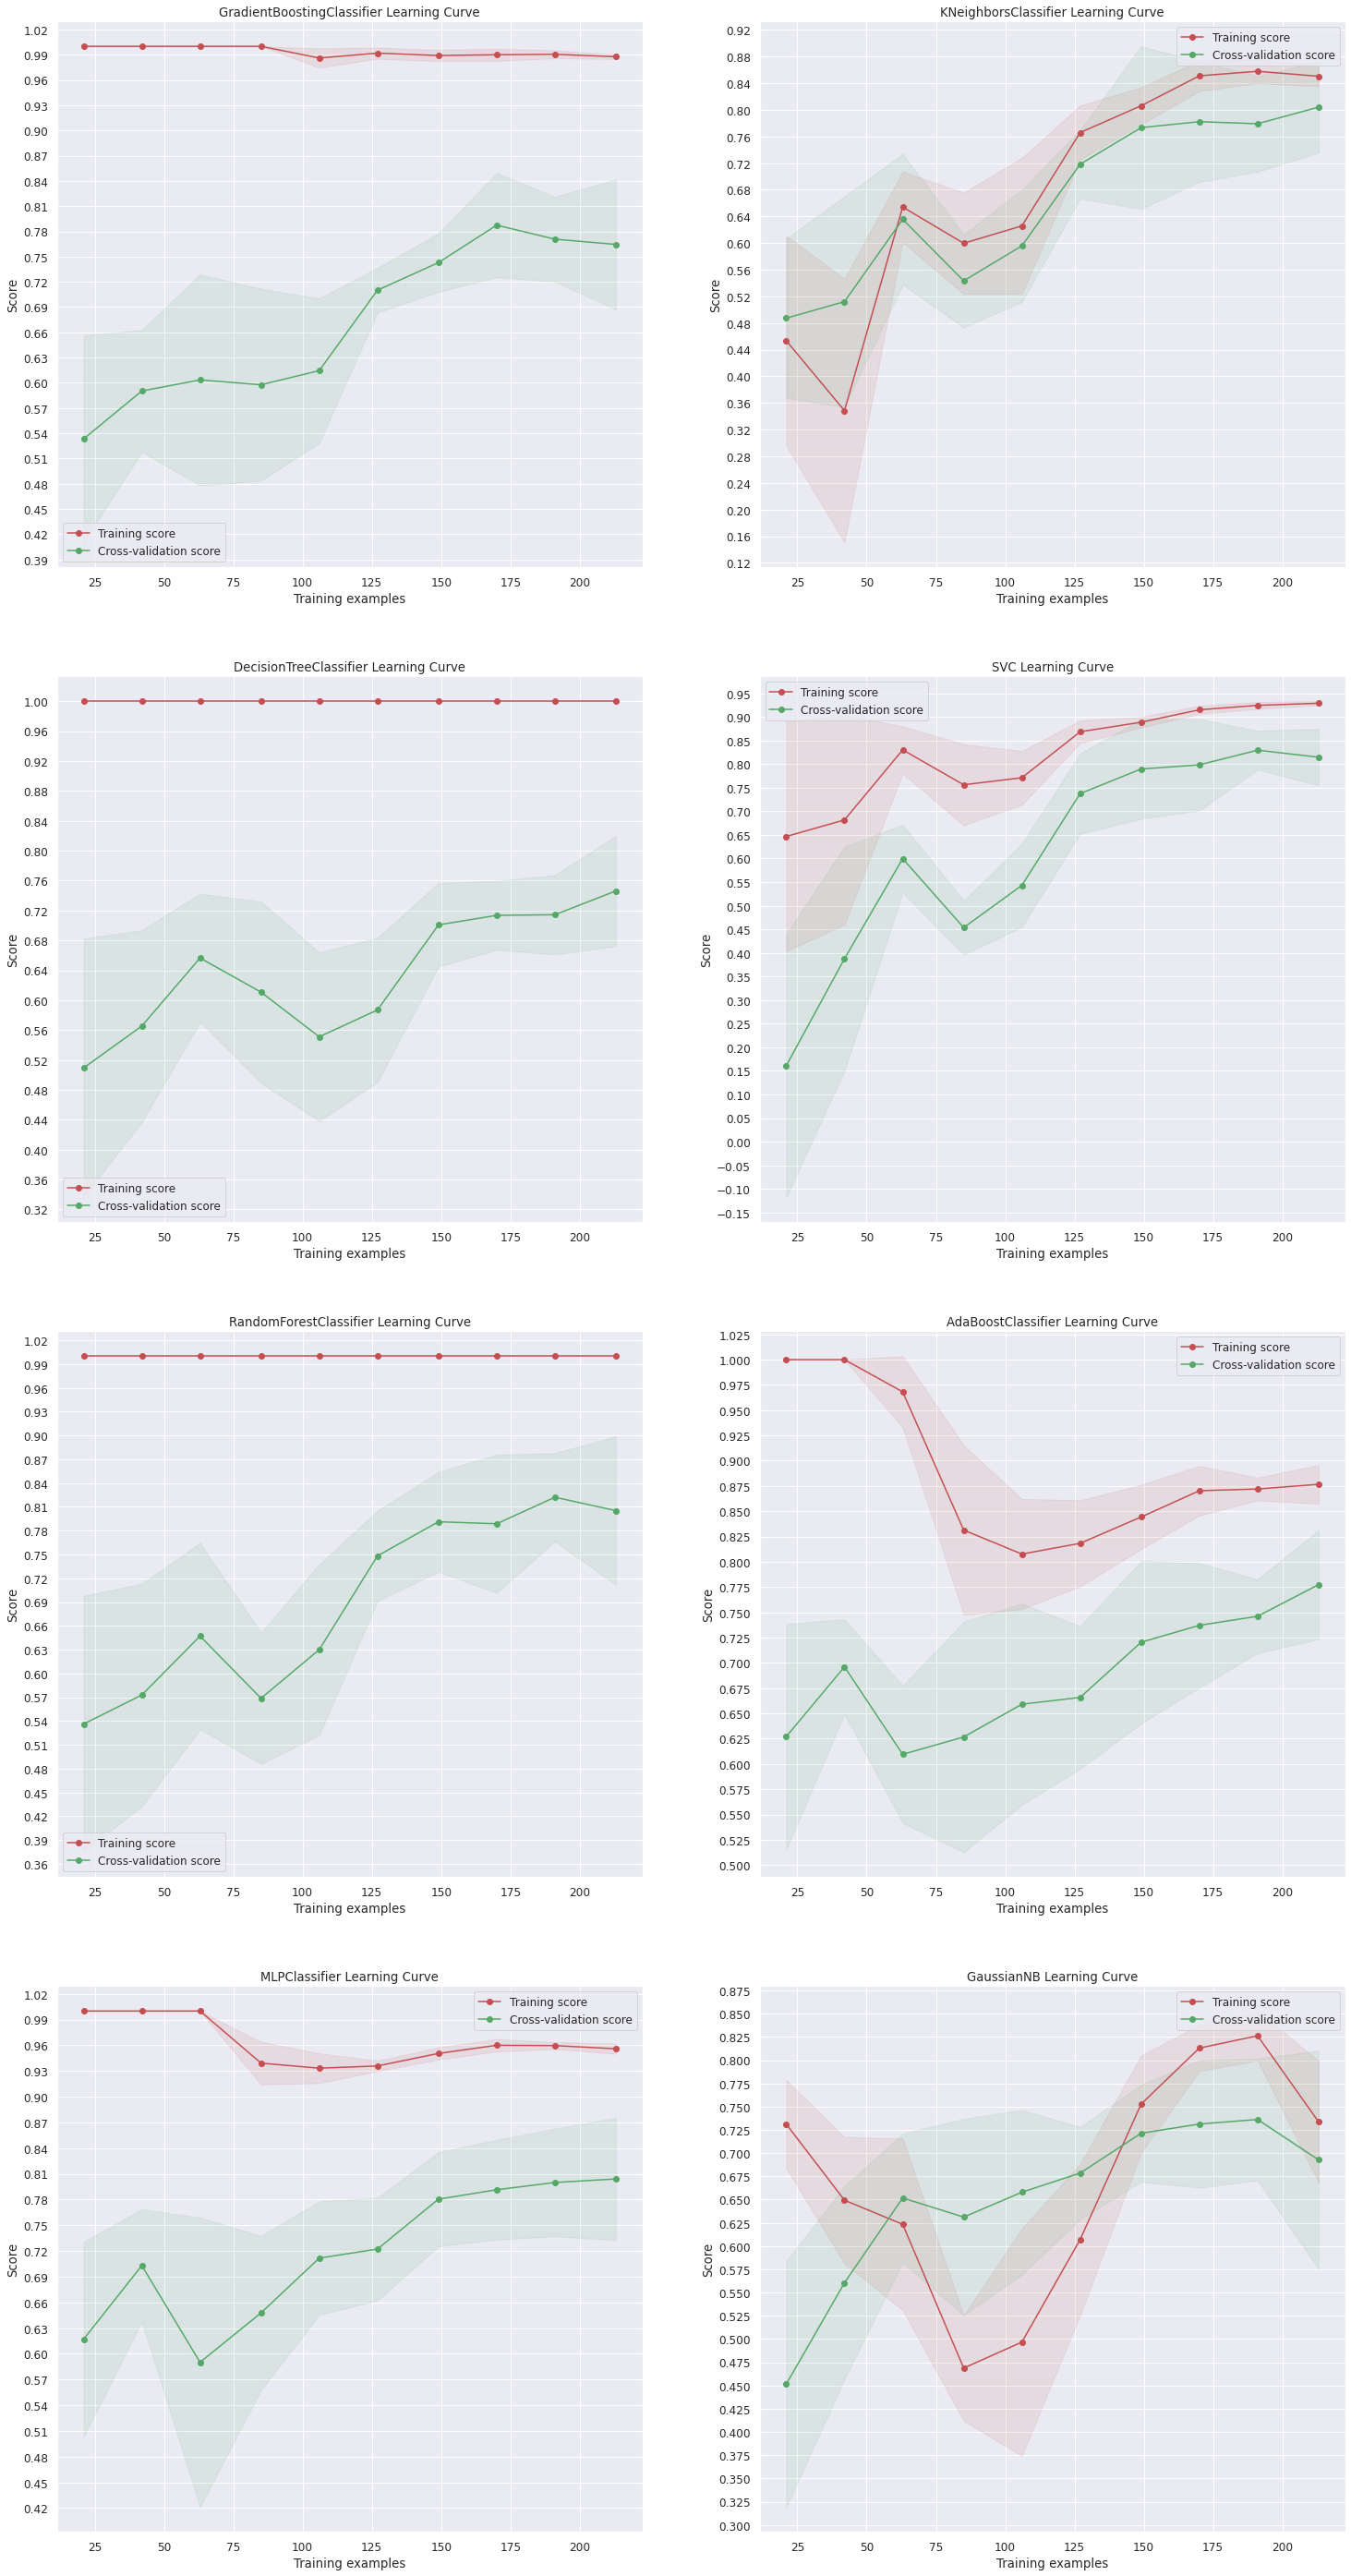

In [41]:
# Displaying learning curves:

plot_learning_curve(classifiers,
                    X_cat,
                    y_eli,
                    ylim=None,
                    cv=cv,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 10))

# RandomizedSearchCV

### Let's get rid of overfitting, one of the easiest ways of doing it is tuning parameters for our estimators and regularize them. Thankfully sklearn is coming to help with useful tools for this case too! We going to use RandomizedSearchCV for this:

    While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

    A budget can be chosen independent of the number of parameters and possible values.

    Adding parameters that do not influence the performance does not decrease efficiency.

### I'm going to choose small amount of estimators and not many parameters to search for timing purposes but you'll see even that's useful!

In [42]:
# Searching parameters for fine tuning:

for i in [randfclass,svc, adaclass]:
    
    if i == svc:
        parameters = {
        'C': [1,3,9,27],
        'tol': [1e-2, 1e-3, 1e-4],
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'shrinking': [True, False]}
        
    if i == randfclass:
        parameters = {
            'max_depth': [2, 3, 5],
            'n_estimators': [50, 100, 150],
            'criterion': ['gini', 'entropy'],
            'bootstrap': [True, False],
        }
        
    if i == adaclass:
        parameters = {
            'base_estimator': [None, dectree],
            'n_estimators': [50, 100, 150],
            'algorithm': ['SAMME','SAMME.R'],
            'learning_rate': [0.8,1,1.2],
        }
    
    
    def hyperparameter_tune(base_model, parameters, n_iter, cv, X, y):
        
        ''' A function for optimizing mutliple classifiers'''
        
        start_time = time.time()
        optimal_model = RandomizedSearchCV(base_model,
                                param_distributions=parameters,
                                n_iter=n_iter,
                                cv=cv,
                                scoring = 'f1',
                                n_jobs=-1,
                                random_state=seed)

        optimal_model.fit(X, y)    


        scores = cross_val_score(optimal_model, X, y, cv=cv,n_jobs=-1, scoring='f1')
        stop_time = time.time()

        print('====================')
        print(f'Updated Parameters for {str(base_model.__class__.__name__)}')
        print('Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}'.format(scores.mean(), scores.std()))
        print('Best Score: {:.3f}'.format(optimal_model.best_score_))
        print('Best Parameters: {}'.format(optimal_model.best_params_))
        print('Elapsed Time:', time.strftime('%H:%M:%S', time.gmtime(stop_time - start_time)))
        print('====================')


        return optimal_model.best_params_, optimal_model.best_score_
    best_params, best_score = hyperparameter_tune(i, parameters, 20, cv, X_cat, y_eli)
    i.set_params(**best_params)

Updated Parameters for RandomForestClassifier
Cross Val Mean: 0.806, Cross Val Stdev: 0.074
Best Score: 0.825
Best Parameters: {'n_estimators': 150, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
Elapsed Time: 00:01:08
Updated Parameters for SVC
Cross Val Mean: 0.785, Cross Val Stdev: 0.083
Best Score: 0.824
Best Parameters: {'tol': 0.001, 'shrinking': False, 'kernel': 'linear', 'C': 3}
Elapsed Time: 00:00:04
Updated Parameters for AdaBoostClassifier
Cross Val Mean: 0.799, Cross Val Stdev: 0.108
Best Score: 0.810
Best Parameters: {'n_estimators': 150, 'learning_rate': 1, 'base_estimator': None, 'algorithm': 'SAMME'}
Elapsed Time: 00:00:33


# Tuned Model Results

### Alright! As you can see even little bit tuned parameters added regularization to our models and increased the CV score for them. That's a good sign! Now we have three decent models to make predictions!

In [43]:
# Checking binned models:

binn_models = model_check(X_cat, y_eli, classifiers, cv)
display(binn_models)

Model Name  Train Roc/AUC Mean  Test Roc/AUC Mean  \
4      RandomForestClassifier            0.986336           0.920793   
3                         SVC            0.955153           0.896235   
5          AdaBoostClassifier            0.957023           0.888808   
1        KNeighborsClassifier            0.948720           0.887218   
6               MLPClassifier            0.989016           0.912274   
0  GradientBoostingClassifier            0.998289           0.903507   
2      DecisionTreeClassifier            1.000000           0.755296   
7                  GaussianNB            0.910170           0.859576   

   Test Roc/AUC Std  Train Accuracy Mean  Test Accuracy Mean  Test Acc Std  \
4          0.028512             0.933518            0.850384      0.042035   
3          0.032921             0.912000            0.846611      0.045802   
5          0.030076             0.882954            0.831796      0.037647   
1          0.028523             0.866118            0.831656      0.038539   
6          0.024780             0.960664            0.828022      0.038418   
0          0.024406             0.988767            0.794270      0.043084   
2          0.034422             1.000000            0.756604      0.031068   
7          0.054004             0.791225            0.763802      0.070959   

   Train F1 Mean  Test F1 Mean  Test F1 Std      Time  
4       0.925724      0.824816     0.070030  0.322677  
3       0.902336      0.823627     0.074126  0.015845  
5       0.871287      0.809974     0.066548  0.417646  
1       0.847943      0.804003     0.068432  0.005810  
6       0.957070      0.803556     0.069567  0.590377  
0       0.987685      0.761383     0.077073  0.143076  
2       1.000000      0.729606     0.048169  0.006655  
7       0.731303      0.692745     0.117705  0.007801

# Dimension Reduction Using PCA

    PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, PCA is implemented as a transformer object that learns components in its fit method, and can be used on new data to project it on these components.

Reducing dimensions is useful for bigger datasets because by transforming a large set of variables into a smaller one that still contains most of the information in the large set makes your modelling faster. This is not the case here since we have very small data but we still can use it for visualization which I find it cool...

In [44]:
# Fitting PCA:

pca = PCA()
pca.fit(X_cat)
pca_samples = pca.transform(X_cat)

## Explained Variance

### This graph shows that first 15 components explains more than 80% of the variance in the data and currently we have 46 of them. So it's safe to reduce some...

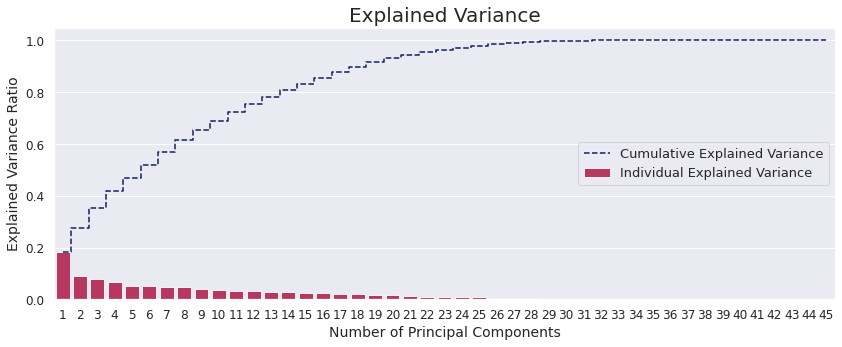

In [45]:
# Explaining variance ratio:

fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(range(X_cat.shape[1]), pca.explained_variance_ratio_.cumsum(), linestyle='--', drawstyle='steps-mid', color=cust_palt[0],
         label='Cumulative Explained Variance')
sns.barplot(np.arange(1,X_cat.shape[1]+1), pca.explained_variance_ratio_, alpha=0.85, color=cust_palt[1],
            label='Individual Explained Variance')

plt.ylabel('Explained Variance Ratio', fontsize = 14)
plt.xlabel('Number of Principal Components', fontsize = 14)
ax.set_title('Explained Variance', fontsize = 20)
plt.legend(loc='center right', fontsize = 13);

## 5 Components

### We start with 5 components. It looks like these 5 explains half of the variance in our data.

In [46]:
# 5 Component PCA:

pca = PCA(5)
pca.fit(X_cat)
pca_samples = pca.transform(X_cat)

In [47]:
# Displaying 50% of the variance:

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f'PC {i+1}' for i in range(5)}
labels['color'] = 'condition'

fig = px.scatter_matrix(
    pca_samples,
    color=y_eli,
    dimensions=range(5),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    opacity=0.8,
    color_continuous_scale=cust_palt,
)
fig.update_traces(diagonal_visible=False)
fig.show()

## 3 Components

### More we reduce dimensions further we can visualize it better for our graphs. At 3D we can have this scatterplot, showing us some kind of meaningful clusters.

In [48]:
# 3 Component PCA:

pca = PCA(3)  # Project from 46 to 3 dimensions.
matrix_3d = pca.fit_transform(X_cat)

In [49]:
# Displaying 3 components:

total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(x=matrix_3d[:, 0], y=matrix_3d[:, 1], z=matrix_3d[:, 2], color=y_eli, opacity=0.8,color_continuous_scale=cust_palt,
                    title=f'Total Explained Variance: {total_var:.2f}%',
                    labels = {'x':'Component 1', 'y':'Component 2','z':'Component 3'})
fig.show()

### On 2D space we can still diverse the clusters according to our target variables. These two components explains almost one third of the variance...

In [50]:
# 2 Component PCA:

pca = PCA(2)  # project from 46 to 2 dimensions
matrix_2d = pca.fit_transform(X_cat)

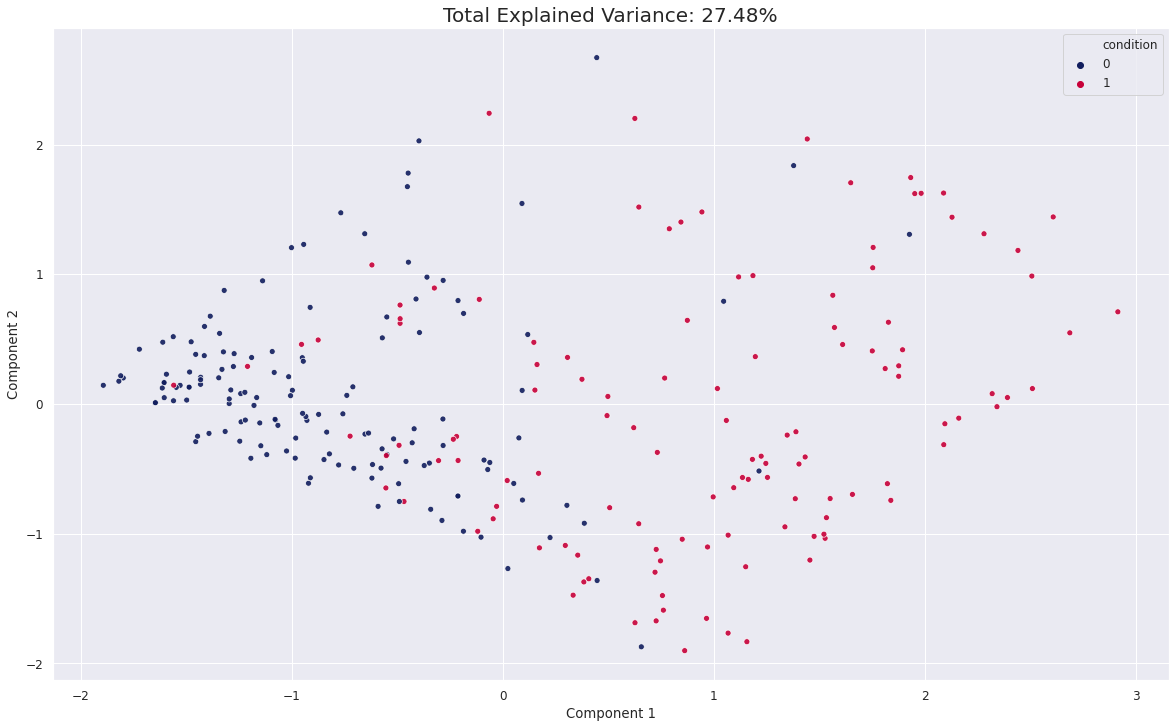

In [51]:
# Displaying 2 PCA:

total_var = pca.explained_variance_ratio_.sum() * 100
fig= plt.figure(figsize=(20, 12))
ax =sns.scatterplot(matrix_2d[:, 0], matrix_2d[:, 1],palette=cust_palt[:2],
            hue=y_eli, alpha=0.9, )
ax.set_title(f'Total Explained Variance: {total_var:.2f}%', fontsize = 20)
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.show()

> # Reduced Dimension Model Results

### These are pretty good results! We almost have same model metrics for most of the classifiers and even got some better regularization for some estimators!

In [52]:
# Reduced Dimension Model Results

model_check(matrix_2d, y_eli, classifiers, cv)

Model Name  Train Roc/AUC Mean  Test Roc/AUC Mean  \
3                         SVC            0.926328           0.929569   
6               MLPClassifier            0.929819           0.922995   
7                  GaussianNB            0.918436           0.919343   
5          AdaBoostClassifier            0.968604           0.895962   
1        KNeighborsClassifier            0.949255           0.887664   
0  GradientBoostingClassifier            0.999877           0.899059   
4      RandomForestClassifier            0.989074           0.898272   
2      DecisionTreeClassifier            1.000000           0.801994   

   Test Roc/AUC Std  Train Accuracy Mean  Test Accuracy Mean  Test Acc Std  \
3          0.008883             0.863301            0.854088      0.023806   
6          0.010296             0.860506            0.850314      0.019413   
7          0.014760             0.853942            0.846541      0.024202   
5          0.044928             0.888601            0.846681      0.035009   
1          0.029496             0.873621            0.839203      0.028923   
0          0.018439             0.996253            0.831656      0.030087   
4          0.016799             0.926010            0.831447      0.037139   
2          0.025648             1.000000            0.801607      0.024556   

   Train F1 Mean  Test F1 Mean  Test F1 Std      Time  
3       0.843687      0.827244     0.055810  0.003143  
6       0.843094      0.824867     0.053522  0.387996  
7       0.834077      0.818967     0.054266  0.001452  
5       0.873652      0.816466     0.075375  0.382576  
1       0.858260      0.813114     0.059517  0.001359  
0       0.995958      0.803520     0.069164  0.109202  
4       0.914932      0.796873     0.078785  0.321675  
2       1.000000      0.783714     0.033462  0.003042

# Decision Regions

### With these contour plots we can see how the models decide on their predictions based on 2D data with confidence intervals. Looks cool!

In [53]:
def prob_reg(X, y):
    
    ''' A function for displaying decision regions'''
    
    from matplotlib.colors import ListedColormap
    figure = plt.figure(figsize=(20, 40))
    h = .02
    i = 1

    # preprocess dataset, split into training and test part
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.2, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Just plot the dataset first
    cm = plt.cm.RdYlGn
    cm_bright = ListedColormap(['#e00d14', '#3ca02c'])
    ax = plt.subplot(5, 2, i)

    # Iterate over classifiers
    for clf in classifiers:
        ax = plt.subplot(math.ceil(len(classifiers) / 2), 2, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, 'decision_function'):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        g = ax.scatter(X_train[:, 0],
                       X_train[:, 1],
                       c=y_train,
                       cmap=cm_bright,
                       edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0],
                   X_test[:, 1],
                   c=y_test,
                   cmap=cm_bright,
                   edgecolors='k',
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

        ax.set_title(clf.__class__.__name__)

        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        plt.legend(handles=g.legend_elements()[0],
                   labels=['No Disease', 'Has Disease'],
                   framealpha=0.3,
                   scatterpoints=1)

        i += 1

    plt.tight_layout()
    plt.show()

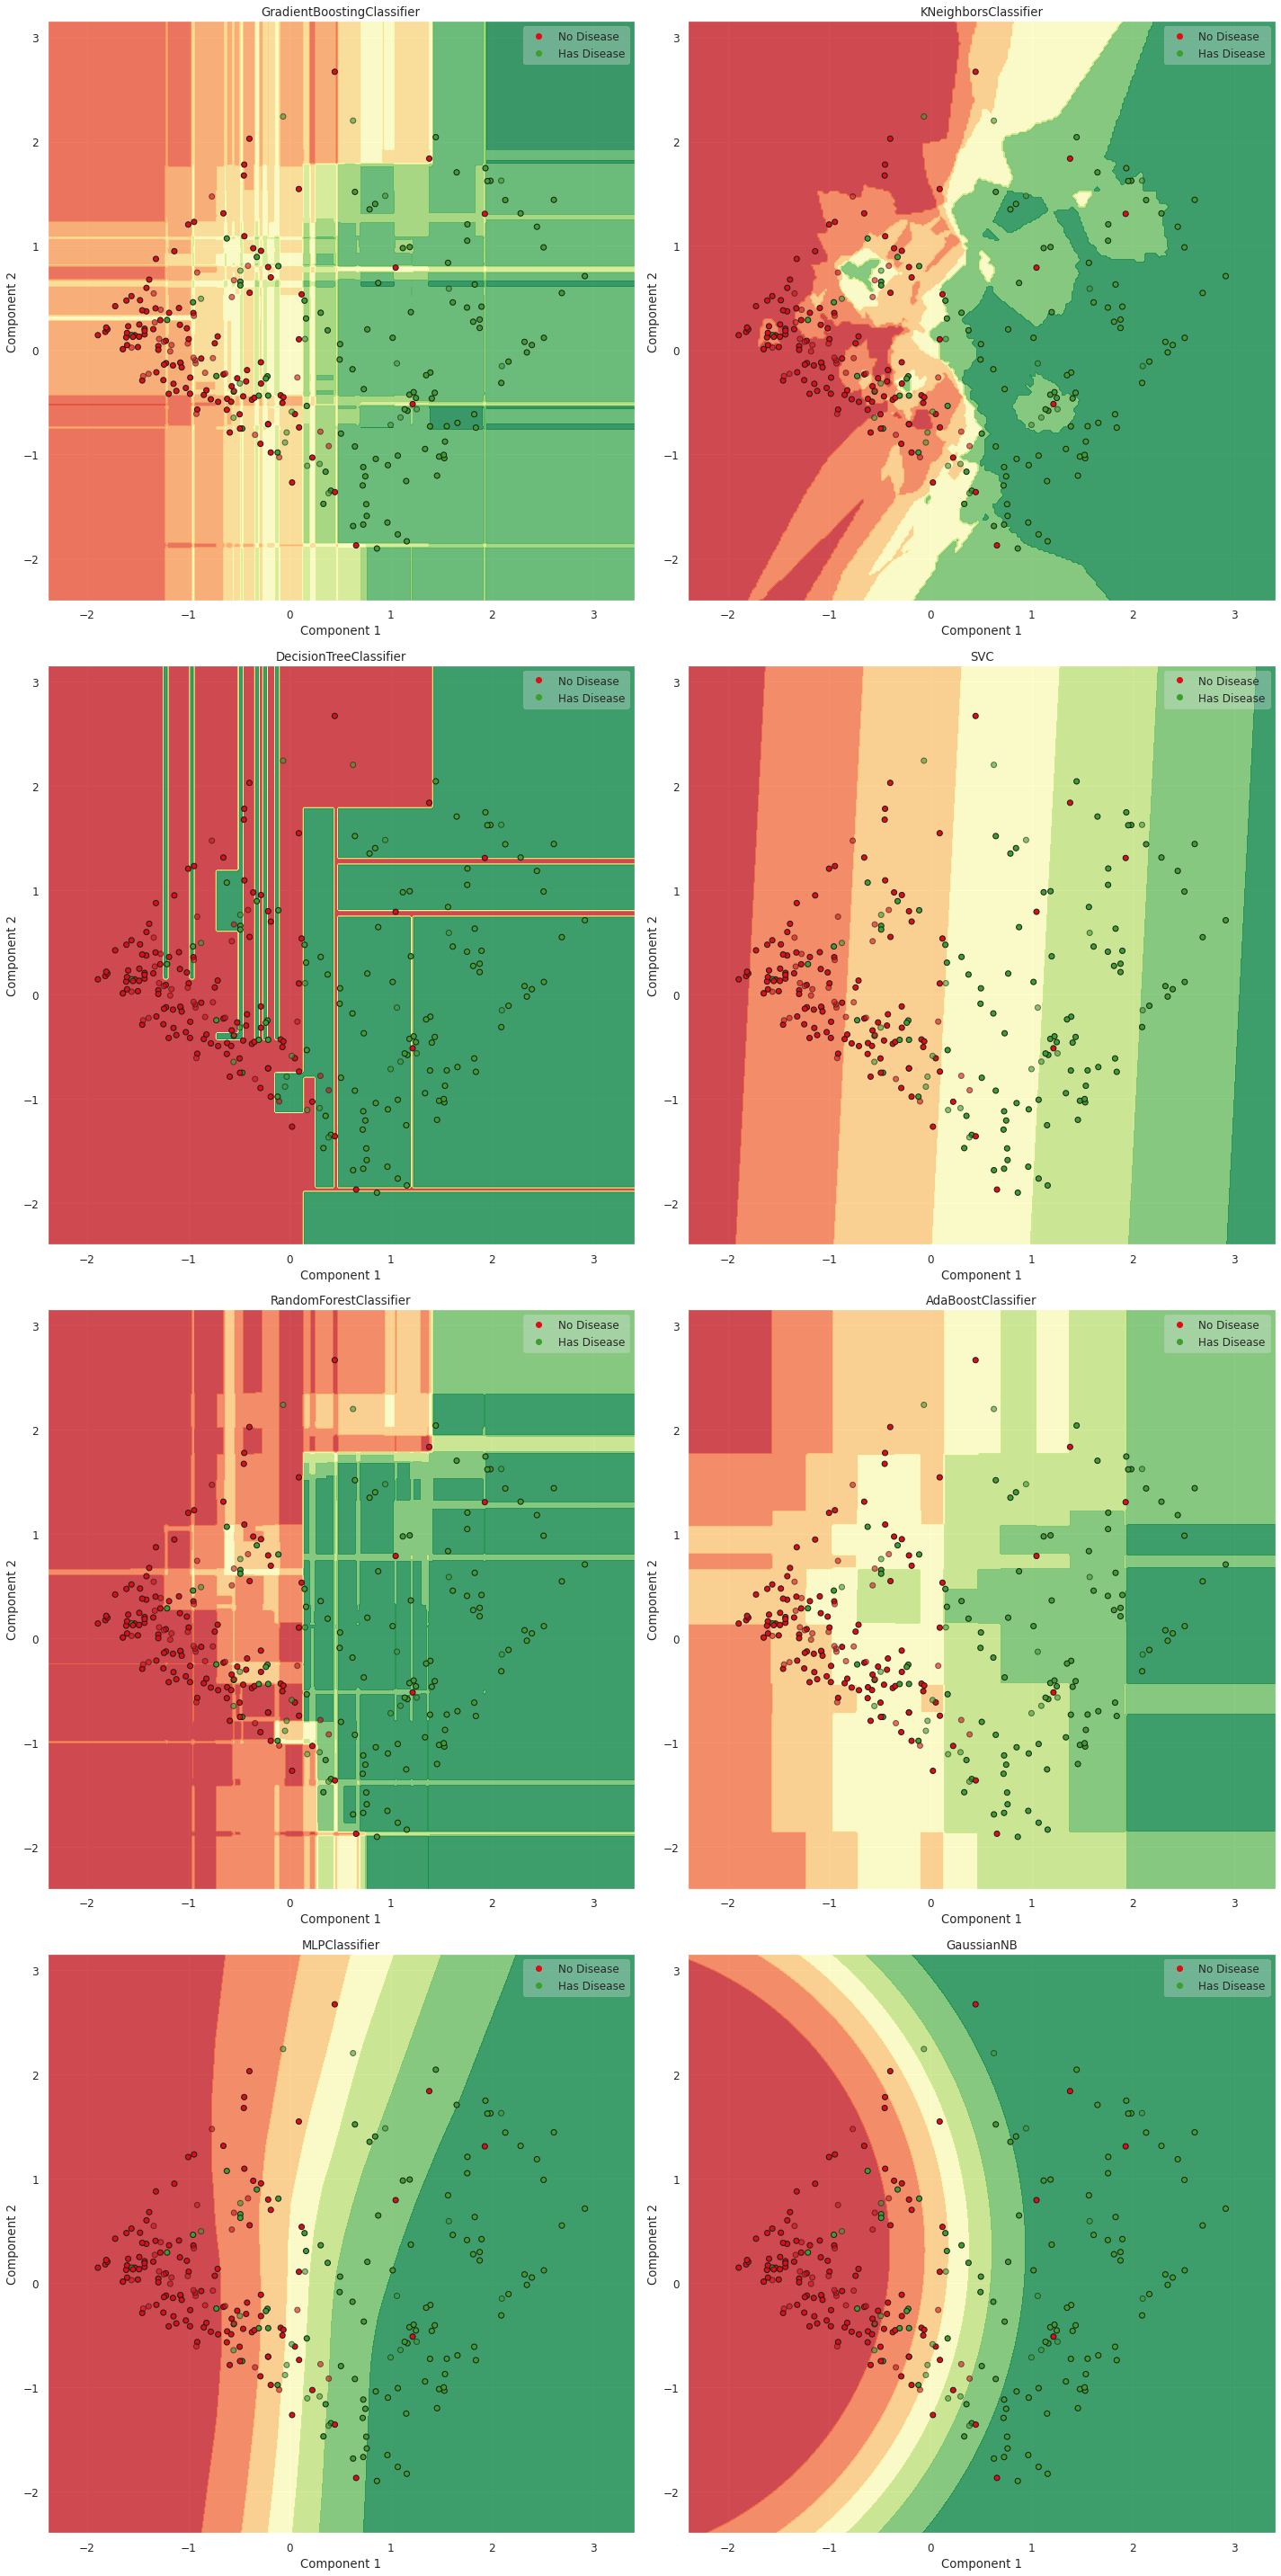

In [54]:
prob_reg(matrix_2d, y_eli)

# Confusion Matrix

### One last thing before we finish our sklearn journey I wanted to use another cool sklearn tool to show confusion matrices for each model. It's important for this case since we don't want our models to predict no disease on actually unhealty person or vice versa. It'd be very bad for patients in actual use. So we want less false positives and negatives but don't forget we still have some overfitted models so be careful about checking overfitted models like decision tree etc.

In [55]:
def conf_mat(X,y, classifiers):
    
    ''' A function for displaying confusion matrices'''
    
    fig, axes = plt.subplots(4,2, figsize=(20,12))
    
    axes = axes.flatten()

    for ax, classifier in zip(axes, classifiers):
        classifier.fit(X,y)
        plot_confusion_matrix(classifier, X, y,
                                         values_format = 'n',
                                         display_labels = ['No Disease', 'Diease'],
                                         cmap='summer_r',ax=ax)
        ax.set_title(f'{classifier.__class__.__name__}')
        ax.grid(False)
        plt.tight_layout()

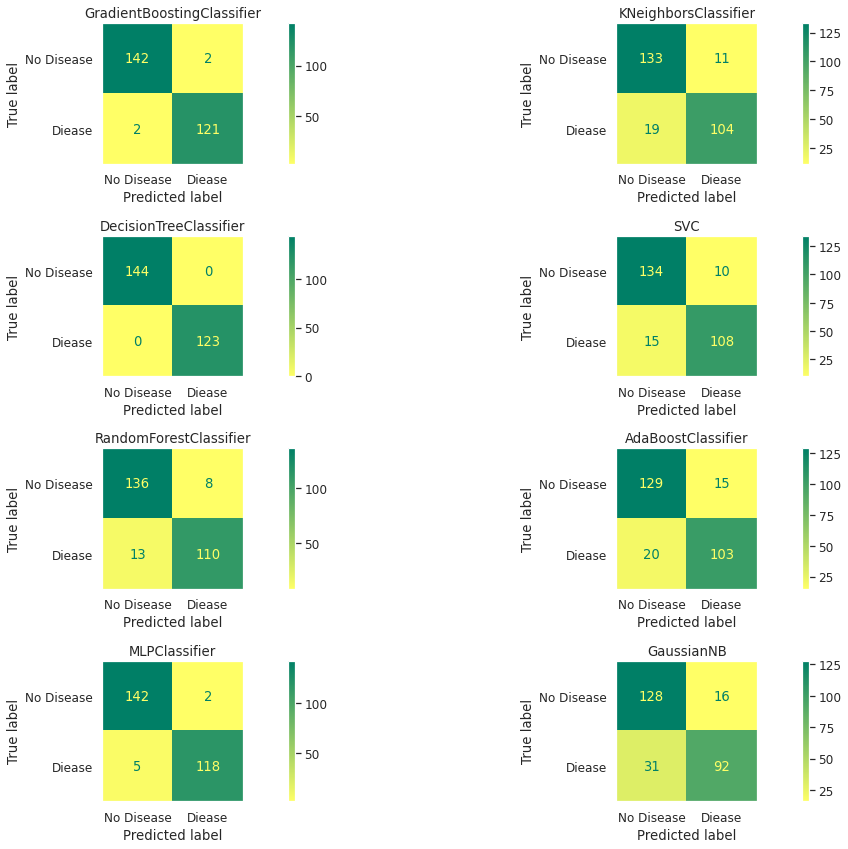

In [56]:
# Displaying confusion matrix for each estimator:

conf_mat(X_cat, y_eli, classifiers)

# Final Words

### Well this concludes my notebook. It was fun sklearn journey for me, I hope you had fun while reading it and thanks for taking a look. 

### Feel free to comment I'll try to answer it all and as usual if you liked my work please don't forget to vote, have good one all!